# Week 0: Exploratory Analysis

In the current post, I present the exploratory analysis of the bike sharing data. I got the data from http://www.bayareabikeshare.com/open-data. The data is prepresented in three different files, which gives information about : all trips that were made, the weather for each date and for each city, and geolocations of stations.

I load the first chunks of data from different files and change name of columns.

In [1]:
import zipfile
import pandas as pd

#'Date', 'Max_Temperature_F', 'Events', 'zip'
z = zipfile.ZipFile('babs_open_data_year_1.zip')
weather = pd.read_csv(z.open('201402_babs_open_data/201402_weather_data.csv'), index_col=False, usecols=[0,1,21,23])

#'station_id','lat','long','landmark'
z = zipfile.ZipFile('babs_open_data_year_1.zip')
stations = pd.read_csv(z.open('201402_babs_open_data/201402_station_data.csv'), parse_dates=True, usecols=[0,2,3,5])

#'Start Date','Start Terminal','Subscription Type'
z = zipfile.ZipFile('babs_open_data_year_1.zip')
trips = pd.read_csv(z.open('201402_babs_open_data/201402_trip_data.csv'), parse_dates=True, usecols=[1,2,4,9,10])


In [2]:
trips = trips.rename(columns={"Start Terminal": "station_id", "Start Date": "date_time", "Subscription Type": "subsc_type"})
trips.date_time = trips.date_time.apply(pd.to_datetime)
trips.loc[:,"Date"] = trips.loc[:,'date_time'].dt.date.apply(pd.to_datetime)


In [3]:
weather.Date = weather.Date.apply(pd.to_datetime)

Before merging, we notice that weather data is given per city. The cities are coded in zip codes. However, in stations 'zip' column has the zip code of stations. To match stations id with weather data, one has to make the correspondence between zipcodes of stations and zip codes of cities. One option is to measure distance between zipcodes. The operation needs internet connection and has asimptotics of O(MxN), where M is the number of unique zip codes of cities and N is the number of unique zip codes of the stations.

Another option is to translate zip codes of cities to coordinates and measure the distance between coordinate. This approach seems to be faster as the funciton of measuring distance between two coordinates does not need an internet connection.


In [4]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()

# Need internet connection to work!!
zcit = pd.Series(weather.zip.unique())

def zip2coor(x):
    # Transfer zip codes to coordinates.
    # In stead of apply function to all, it is faster
    # to apply to unique values of zip the merge

    loca = geolocator.geocode('CA:'+str(x),timeout=20) 
    # as we are in California added CA:. otherwise work not in all cases
    return pd.Series({'lat_cit':loca.latitude,'long_cit':loca.longitude, 'zip':int(x)})

zipcoor = zcit.apply(zip2coor)
#make zip int instead of float.
zipcoor.zip = zipcoor.zip.apply(int) 

weather = weather.merge(zipcoor, on='zip') #add coordinates to weather


Now 'weather' data frame has two more columns 'lat_cit' and 'lat_cit', which consist of coordinates of the cities. I create the same columns for 'stations' data frame by measuring distance berween the coordinates of station and closest city.

In [5]:
# the function distance do not use Internet
from geopy.distance import vincenty

def get_cit_coor(x):
    # TODO: put zipcoor as argument, now global from previous cell
    c_stat = (x[0],x[1])
    mdist=1e3
    for i in xrange(zipcoor.size):
        c_city = (zipcoor.lat_cit[0],zipcoor.long_cit[0])
        dist = vincenty(c_city, c_stat).kilometers
        if dist < mdist:
            mdist = dist
            coor=c_city
    return pd.Series({'lat':x[0],'long':x[1],'lat_cit':coor[0],'long_cit':coor[1]})
    

stations = stations.merge(stations.loc[:,['lat','long']].apply(get_cit_coor,axis=1),on=['lat','long'])

del zipcoor

Both 'stations' and 'weather' has 'lat_cit' and 'long_cit' columns. 'trips' can be merges with others on 'stations_id'

In [6]:
result = trips.merge(stations, on = 'station_id')
result = result.merge(weather, on = ['Date','lat_cit','long_cit'])


Some minor changes to data.

In [7]:
result.Events[result.Events=='rain'] = 'Rain'
result.Events[pd.isnull(result.Events)]='Sun'

def Far2Cels(x):
    return (x  - 32.)/1.8
result['day_of_week'] = result['Date'].dt.weekday_name
result.Max_Temperature_F = result.Max_Temperature_F.apply(Far2Cels)

del trips
del weather
del stations

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Duration of trips is distributed in the following way

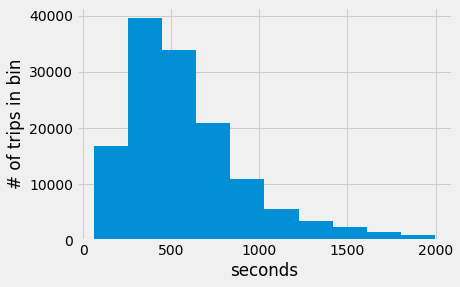

In [8]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('fivethirtyeight')



result.Duration[result.Duration<2000].hist()
plt.xlabel("seconds")
plt.ylabel("# of trips in bin")

In [9]:
#TODO: make a pie from it

print "normal trips", result.Duration[result.Duration<2000][result.Duration>300].count()
print "short trips", result.Duration[result.Duration<300].count()
print "long trips", result.Duration[result.Duration>100000].count()
print "all trips", result.Duration.count()


normal trips 109540
short trips 25921
long trips 60
all trips 144015


For analysis we take the trips that lasts more than five minutes. Others trips can be cosidered as tests and are not relevant for further analysis

In [10]:
result = result[result.Duration>300]

There are four different weather events possible: Rain, Fog, Fog-Rain and Sun. Estimating Fog-Rain as realy rare event in CA, I do not consider Fog-Rain event to Rain.

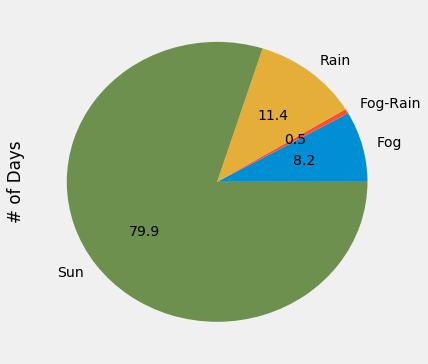

In [11]:
EvDa = result.groupby(['Events','Date']).size()
EvDa.groupby(level=0).size().plot.pie(autopct='%.1f', figsize=(6, 6))
plt.ylabel("# of Days")

# drop Fog-Rain
result=result.drop(result.loc[result.Events=='Fog-Rain'].index)
del EvDa

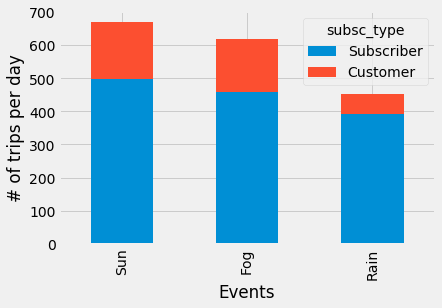

In [12]:
#TODO: Split on subscribers and Customers
EvDa = result.groupby(['Events','Date'],sort=False).size()
Days = EvDa.groupby(level=0,sort=False).size()
Ev   = result.groupby(['Events','subsc_type'],sort=False).size()
Ev.div(Days).unstack('subsc_type').plot.bar(stacked=True)

plt.ylabel("# of trips per day")

del EvDa
del Ev

People in CA prefer to use bicycle in sunny weather and do not like to ride in rain.

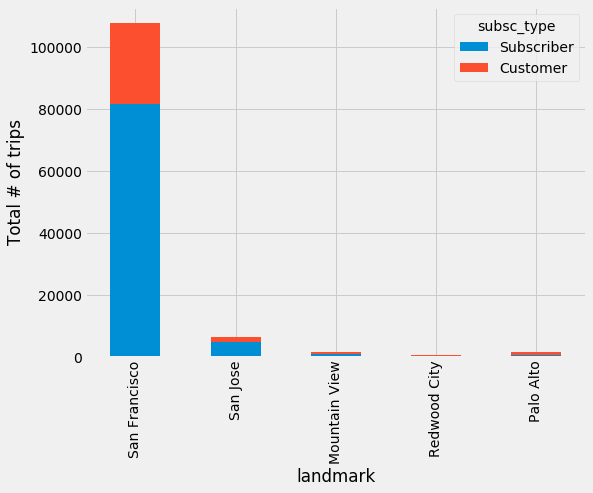

In [13]:
result.groupby(['subsc_type','landmark'],sort=False).date_time.count().unstack('subsc_type').plot(kind='bar',stacked=True,figsize=(8,6))
plt.ylabel("Total # of trips")

Also data consist mostly from data from SF. Other cities are small. TODO: think about to take only SF.

We present plot of Maximum temperature per day and # of trips depending on the date. Here we can see certain correlation between temperature and total # of rides.

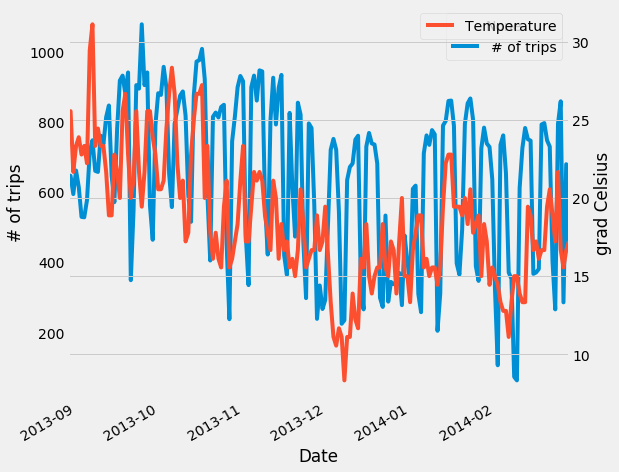

In [14]:
result.groupby('Date').size().plot(figsize=(8, 8), label='# of trips')
plt.legend()
plt.ylabel("# of trips")
result.groupby('Date').Max_Temperature_F.mean().plot(secondary_y=True,label='Temperature')
plt.legend()
plt.ylabel("grad Celsius")

Depending on the day of week, Subscribers and Customers use bycicles in a different way. Subscribers prefer to ride on the week, and customers on the weekend.

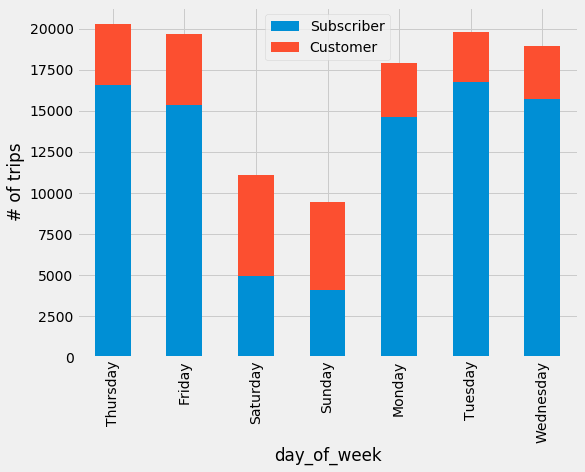

In [15]:
result.groupby(['subsc_type','day_of_week'],sort=False).date_time.count().unstack('subsc_type').plot(kind='bar',stacked=True,figsize=(8,6))
plt.ylabel('# of trips')
plt.legend(loc='best')

The same split can be observed on the distribution of rides during the day.

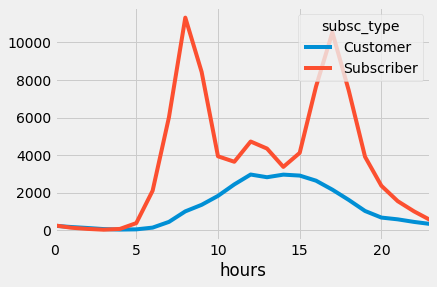

In [16]:
result.loc[:,'hours'] = result.date_time.dt.hour
result.groupby(['subsc_type','hours'], sort=True).date_time.count().unstack('subsc_type').plot()#color='black')
#plt.ylabel("Total # of trips")
#plt.legend(loc=2)
#result
#result

One can deduce that Customers use bicycles for rides during the day, and subscribers during the hours to go to work and back home, as well as during lunch time.

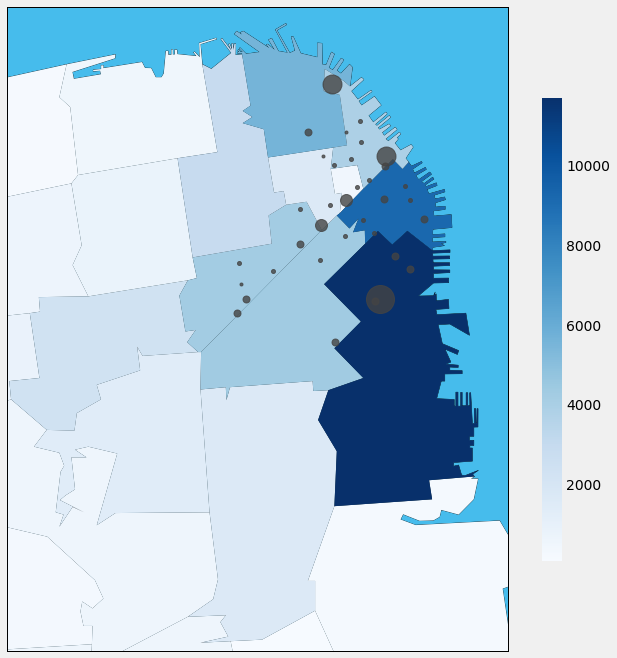

In [143]:
import matplotlib.pyplot as plt
import matplotlib.cm
 
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize


fig, ax = plt.subplots(figsize=(10,20))
#coordinates are taken from http://boundingbox.klokantech.com/

coorlist=[-122.4570465088,37.7305387457,-122.3739624023,37.8149373761]
m = Basemap(resolution='i', # c, l, i, h, f or None
            projection='merc',
            llcrnrlon=coorlist[0], llcrnrlat= coorlist[1], urcrnrlon=coorlist[2], urcrnrlat=coorlist[3])



m.drawmapboundary(fill_color='#46bcec')
#m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
#m.drawcoastlines()

m.readshapefile('df986nv4623', 'areas')

import numpy as np

poly = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.areas],
        'Zip Code': [area['zip_code_5'] for area in m.areas_info]
    })

ds = result.groupby(['Zip Code']).size()
ds = pd.DataFrame({
        'Zip Code': [i for i in ds.index],
        'Count': [j for j in ds.values]
    })
poly = poly.merge(ds, on='Zip Code', how='left')
poly = poly[poly.Count == poly.Count]
poly = poly[poly.Count > 50]

##### color area
cmap = plt.get_cmap('Blues')
#matplotlib.style.use('fivethirtyeight') 
pc = PatchCollection(poly.shapes, zorder=2)
norm = Normalize()
 
pc.set_facecolor(cmap(norm(poly['Count'].fillna(0).values)))
ax.add_collection(pc)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

mapper.set_array(poly['Count'])
plt.colorbar(mapper, shrink=0.4)
###########
#### add dots
resmap = result.groupby(['lat','long']).size()
for ni, pos in enumerate(resmap.index):
    #TODO: make in pandas style
    x, y = m(pos[1],pos[0])
    count = resmap.values[ni]
    size = (count/1500) ** 2 + 3
    m.plot(x, y, 'o', markersize=size, color='#444444', alpha=0.8)
####

plt.show()

